# Prepare training data

This notebook prepares a training dataset. 

Taking the Planck GNILC-separated dust intensity map, we cut out $10^\circ$ by $10^\circ$ patches, distributed in overlapping areas of the sphere. There are $\sim 3000$ of these flat-sky projections, which are saved to a netcdf file by `xarray`.

In [1]:
import dustvaeder
from dustvaeder.tools import get_patch_centers, FlatCutter

import healpy as hp
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False

import h5py
from pathlib import Path

from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, Galactic
from astropy import units as u
from astropy.io import fits

import cosmoplotian.projections
import cosmoplotian.colormaps
import ligo.skymap.plot

## Inputs

Input directory is specified, and map path.

In [2]:
import requests

Get the GNILC estimate of the thermal dust I Stokes parameter at 545 GHz from Planck Legacy archive. Make data directory on scratch partition if it does not already exist.

In [3]:
DIR = Path("/global/cscratch1/sd/bthorne/dustvaeder")
DIR.mkdir(exist_ok=True)

URL = "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_Dust-GNILC-F545_2048_R2.00.fits"
MAP_FNAME = "COM_CompMap_Dust-GNILC-F545_2048_R2.00.fits"
MAP_PATH = DIR / MAP_FNAME

if not MAP_PATH.exists():
    req = requests.get(URL, stream=True, allow_redirects=True)
    with open(MAP_PATH, 'wb') as f:
        for chunk in req.iter_content(8096):
            if chunk:
                f.write(chunk)

HDU = fits.open(MAP_PATH)

Read in the I Stokes parameter as float 32.

In [4]:
display(HDU[1].header)
I_GNILC = hp.reorder(HDU[1].data['I'].astype(np.float32), inp=HDU[1].header['ORDERING'], out='RING')

XTENSION= 'BINTABLE'           /Written by IDL:  Fri May  6 14:35:26 2016       
BITPIX  =                    8 /                                                
NAXIS   =                    2 /Binary table                                    
NAXIS1  =                    4 /Number of bytes per row                         
NAXIS2  =             50331648 /Number of rows                                  
PCOUNT  =                    0 /Random parameter count                          
GCOUNT  =                    1 /Group count                                     
TFIELDS =                    1 /Number of columns                               
TFORM1  = 'E       '           /Real*4 (floating point)                         
TTYPE1  = 'I       '           / Intensity map                                  
PIXTYPE = 'HEALPIX '           / HEALPIX pixelisation                           
ORDERING= 'RING    '           / Pixel ordering scheme, either RING or NESTED   
NSIDE   =                 20

In [6]:
import os
PLOT_DIR = Path(os.path.expandvars("$HOME")) / 'vae-paper' / 'figures'
PLOT_DIR.mkdir(exist_ok=True, parents=True)

/global/u1/b/bthorne/projects/DustVAEder/env/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bboc_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  


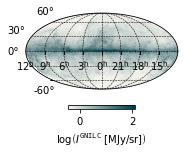

In [9]:
from astropy.coordinates import Galactic, ICRS

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3, 2), subplot_kw={
    'projection': 'cosmo hours mollweide',
})
ax.grid(linestyle='--', linewidth=0.5, color='k')
img = ax.imshow_hpx((np.log10(I_GNILC), Galactic()), cmap='lin blu')

cb = plt.colorbar(img, orientation='horizontal', shrink=0.4, ax=ax)
#cb.ax.xaxis.set_ticks([0, 500, 1000])
cb.solids.set_edgecolor('face')
cb.set_label(r"$\log{\left( I^{\tt GNILC}~[\rm MJy/sr] \right)}$")

fig.savefig(PLOT_DIR / "GNILC_545GHz.pdf", bboc_inches='tight')

## Cutting scheme

In [11]:
# Linear number of pixels
RES = 256
# How much of the Galaxy to leave out (will be 2 * GAL_CUT total), in degrees
GAL_CUT = 5 * u.deg
# Step size in azimuth in degrees. This is adapted by a factor of cosine with latitude.
STEP_SIZE = 4 * u.deg

centers = get_patch_centers(GAL_CUT, STEP_SIZE)
print(len(centers))

2261


Text(0.5, 0, '$b~{\\rm [^\\circ]}$')

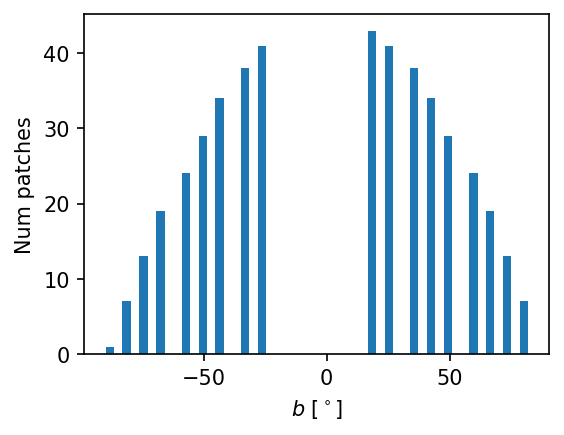

In [32]:
lons, lats = zip(*centers)
lons = np.array([lon.value for lon in lons])
lats = np.array([lat.value for lat in lats])

fig, ax = plt.subplots(1, 1, dpi=150, figsize=(4, 3))
ax.hist(lats, bins=50)
ax.set_ylabel(r"Num patches")
ax.set_xlabel(r"$b~{\rm [^\circ]}$")

## Cutting the map

We then have to specify the size of the patch to cut around each center. Here we do $20^\circ$.

In [12]:
# Total angular length of each side
ANG_X = 8. * u.deg
ANG_Y = 8. * u.deg

# cut out maps at each of the patch centers
cutter = FlatCutter(ANG_X, ANG_Y, RES, RES)
cut_maps = np.array([cutter.rotate_to_pole_and_interpolate(lon, lat, I_GNILC) for (lon, lat) in centers])

The `cut_maps` array is already in the `tensorflow` form of $(n_{\rm batch}, n_x, n_y, n_{\rm channels})$:

In [13]:
print(centers[50])
print(centers[100])
print(centers[901])
print(centers[1500])

(<Quantity 145.11821114 deg>, <Quantity -74. deg>)
(<Quantity 39.33749337 deg>, <Quantity -66. deg>)
(<Quantity 197.67489816 deg>, <Quantity -18. deg>)
(<Quantity 150.05939698 deg>, <Quantity 25. deg>)


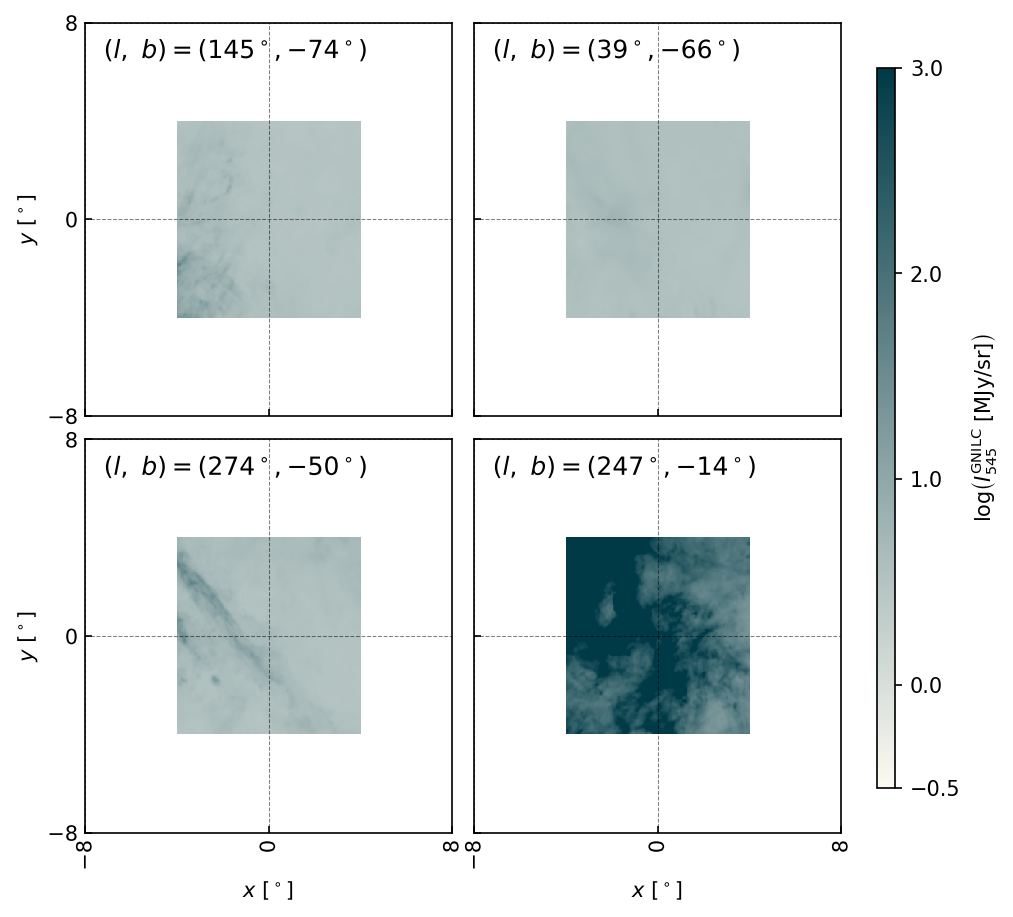

In [14]:
# plot maps at these indices
i = [50, 100, 321, 1000]

fig, axes = plt.subplots(ncols=2, nrows=2, dpi=150, figsize=(6, 6), sharex=True, sharey=True)
dim = ANG_X.value.astype(int)
kwds = {
    'extent': [- dim / 2, dim / 2, - dim / 2, dim / 2],
    'aspect': 'auto',
    'interpolation': 'nearest',
    'origin': 'lower',
    'cmap': 'lin blu',
    'vmin': -0.5,
    'vmax': 3.
}

axes[0, 0].imshow(cut_maps[i[0], :, :, 0], **kwds)
axes[0, 0].set_ylabel(r"$y~{\rm [^\circ]}$")
axes[0, 1].imshow(cut_maps[i[1], :, :, 0], **kwds)
axes[1, 0].imshow(cut_maps[i[2], :, :, 0], **kwds)
axes[1, 0].set_ylabel(r"$y~{\rm [^\circ]}$")
axes[1, 0].set_xlabel(r"$x~{\rm [^\circ]}$")
img = axes[1, 1].imshow(cut_maps[i[3], :, :, 0], **kwds)
axes[1, 1].set_xlabel(r"$x~{\rm [^\circ]}$")

axes[0, 0].annotate(f"$(l, ~b)=({{{centers[i[0]][0].value:.0f}^\circ}}, {{{centers[i[0]][1].value:.0f}^\circ}})$", xy=(0.05, 0.91), xycoords='axes fraction', fontsize=12)
axes[0, 1].annotate(f"$(l, ~b)=({{{centers[i[1]][0].value:.0f}^\circ}}, {{{centers[i[1]][1].value:.0f}^\circ}})$", xy=(0.05, 0.91), xycoords='axes fraction', fontsize=12)
axes[1, 0].annotate(f"$(l, ~b)=({{{centers[i[2]][0].value:.0f}^\circ}}, {{{centers[i[2]][1].value:.0f}^\circ}})$", xy=(0.05, 0.91), xycoords='axes fraction', fontsize=12)
axes[1, 1].annotate(f"$(l, ~b)=({{{centers[i[3]][0].value:.0f}^\circ}}, {{{centers[i[3]][1].value:.0f}^\circ}})$", xy=(0.05, 0.91), xycoords='axes fraction', fontsize=12)


for ax in axes.flatten():
    ax.xaxis.set_ticks([-dim, 0, dim])
    ax.yaxis.set_ticks([-dim, 0, dim])
    ax.grid(linestyle='--', linewidth=0.5, color='k', alpha=0.5)
    ax.tick_params(axis='both', direction='in')
    ax.tick_params(axis='x', rotation=90)
    ligo.skymap.plot.outline_text(ax)
    
fig.subplots_adjust(bottom=0.05, top=0.95, left=0.05, right=0.89, wspace=0.06, hspace=0.06)

cbax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
cbar = fig.colorbar(img, cax=cbax)

cbar.set_ticks([-0.5, 0, 1, 2, 3])
cbar.set_label(r"$\log{\left(I^{\rm GNILC}_{545}~{[\rm MJy / sr]} \right)}$")

## Save data as xarray Dataset

In [15]:
import xarray as xr

I_DATASET = xr.Dataset({
    'I_GNILC': (('batch', 'x', 'y', 'channel'), cut_maps),
},
    coords={
        'batch': np.arange(cut_maps.shape[0]),
        'x': np.arange(RES),
        'y': np.arange(RES),
        'channel': np.arange(1)
    }
)

In [16]:
display(I_DATASET)

<xarray.Dataset>
Dimensions:  (batch: 2261, channel: 1, x: 256, y: 256)
Coordinates:
  * batch    (batch) int64 0 1 2 3 4 5 6 ... 2254 2255 2256 2257 2258 2259 2260
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 247 248 249 250 251 252 253 254 255
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 247 248 249 250 251 252 253 254 255
  * channel  (channel) int64 0
Data variables:
    I_GNILC  (batch, x, y, channel) float64 0.4878 0.4895 ... 0.6568 0.6766

In [22]:
fpath = DIR / "I_GNILC_DATASET.cdf"
I_DATASET.to_netcdf(fpath, mode='w')
I_DATASET_read = xr.open_dataset(fpath)
print(fpath)
I_DATASET_read

/global/cscratch1/sd/bthorne/dustvaeder/I_GNILC_DATASET.cdf


<xarray.Dataset>
Dimensions:  (batch: 2261, channel: 1, x: 256, y: 256)
Coordinates:
  * batch    (batch) int32 0 1 2 3 4 5 6 ... 2254 2255 2256 2257 2258 2259 2260
  * x        (x) int32 0 1 2 3 4 5 6 7 8 ... 247 248 249 250 251 252 253 254 255
  * y        (y) int32 0 1 2 3 4 5 6 7 8 ... 247 248 249 250 251 252 253 254 255
  * channel  (channel) int32 0
Data variables:
    I_GNILC  (batch, x, y, channel) float64 ...

## Normalize the data in several ways to provide for training.

First we provide a set of images normalized by the global minimum and maximum.

In [18]:
cut_maps = np.log(cut_maps) 
log_cut_min = cut_maps.min()
log_cut_max = cut_maps.max()

In [ ]:
cut_maps = 2 * (cut_maps - cut_maps.min()) / (cut_maps.max() - cut_maps.min()) - 1.

In [ ]:
record_dir = Path("../data/preprocessed/")
fpath = record_dir / "GNILC_dust_map_{:d}_st{:d}_gcut{:d}.npy".format(RES, int(STEP_SIZE), int(GAL_CUT))

In [ ]:
np.save(fpath, cut_maps)

In [ ]:
def gen_to_real(log_min, log_max, ma):
    return np.exp((1. + ma) / 2 * (log_max - log_min) + log_min)

## Generator

    

In [ ]:
import tensorflow as tf
gen = tf.keras.models.load_model("../models/generator.h5")

In [ ]:
gen_arr = gen.predict(np.random.randn(1033, 64))

In [ ]:
gen_arr_exp = gen_to_real(log_cut_min, log_cut_max, gen_arr)

In [ ]:
print(norm_log_cut_maps.min())
print(norm_log_cut_maps.max())
print(gen_arr.min())
print(gen_arr.max())

In [ ]:
vmin = None
vmax = None
fig, ax = plt.subplots(3, 4, figsize=(16, 12), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.05, wspace=0.05)
for a in ax[0].ravel():
    a.imshow(cut_maps[np.random.randint(0, 1033), :, :, 0], interpolation='nearest', origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
for a in ax[1].ravel():
    a.imshow(gen_arr[np.random.randint(0, 1033), :, :, 0], interpolation='nearest', origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
for a in ax[2].ravel():
    a.imshow(kev_train_images[np.random.randint(0, 1033), :, :, 0], interpolation='nearest', origin='lower', aspect='auto', vmin=vmin, vmax=vmax)

## Power spectrum 

Also calculate the power spectrum of the maps for use in training. This is implemented with `NaMaster`1

In [ ]:
import pymaster as nmt

cut_maps_arr = np.load(fpath)
xlen = 10
ylen = 10
xres = 256
yres = 256

In [ ]:
Lx = 2 * xlen * np.pi/180
Ly = 2 * ylen * np.pi/180
Nx = xres
Ny = yres


In [ ]:
mask = np.ones(Nx * Ny).reshape((Nx, Ny))
xarr = np.ones(Ny)[:, None] * np.arange(Nx)[None, :] * Lx/Nx
yarr = np.ones(Nx)[None, :] * np.arange(Ny)[:, None] * Ly/Ny

In [ ]:
mask = nmt.mask_apodization_flat(mask, Lx, Ly, aposize=1., apotype="C1")

In [ ]:
f0 = nmt.NmtFieldFlat(Lx, Ly, mask, [cut_maps_arr[100, :, :, 0]])
l0_bins = np.arange(Nx/8) * 8 * np.pi/Lx
b = nmt.NmtBinFlat(l0_bins, l0_bins)

In [ ]:
w00 = nmt.NmtWorkspaceFlat()
w00.compute_coupling_matrix(f0, f0, b)

In [ ]:
def get_uncoupled_spectrum(wsp, field0, nmtbin):
    cl_coupled = nmt.compute_coupled_cell_flat(field0, field0, nmtbin)
    return wsp.decouple_cell(cl_coupled)

cl = np.empty((cut_maps_arr.shape[0], b.get_n_bands()))
cl_gen = np.empty((cut_maps_arr.shape[0], b.get_n_bands()))
for i in range(cut_maps_arr.shape[0]):
    field = nmt.NmtFieldFlat(Lx, Ly, mask, [cut_maps_arr[i, :, :, 0]])
    cl[i] = get_uncoupled_spectrum(w00, field, b)
    #field_gen = nmt.NmtFieldFlat(Lx, Ly, mask, [gen_arr_exp[i, :, :, 0]])
    #cl_gen[i] = get_uncoupled_spectrum(w00, field_gen, b)

In [ ]:
ells_uncoupled = b.get_effective_ells()

In [ ]:
fig, ax = plt.subplots(1, 1)
for i in range(cut_maps_arr.shape[0]):
    ax.loglog(ells_uncoupled, cl_gen[i])
ax.set_xlabel(r"$\ell_b$")
ax.set_ylabel(r"$C_\ell$")

In [ ]:
pcts = np.percentile(np.log10(cl), [5, 32, 50, 68, 95], axis=0) / np.mean(np.log10(cl), axis=0)
pcts_gen = np.percentile(np.log10(cl_gen), [5, 32, 50, 68, 95], axis=0) / np.mean(np.log10(cl_gen), axis=0)

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(ells_uncoupled, pcts[0], '-.C0')
ax.plot(ells_uncoupled, pcts[1], '--C0')
ax.plot(ells_uncoupled, pcts[2], 'C0', label='Planck 353 Training Set')
ax.plot(ells_uncoupled, pcts[3], '--C0')
ax.plot(ells_uncoupled, pcts[4], '-.C0')
ax.plot(ells_uncoupled, pcts_gen[0], '-.C3')
ax.plot(ells_uncoupled, pcts_gen[1], '--C3')
ax.plot(ells_uncoupled, pcts_gen[2], 'C3', label='Samples from Generator')
ax.plot(ells_uncoupled, pcts_gen[3], '--C3')
ax.plot(ells_uncoupled, pcts_gen[4], '-.C3')
ax.set_xlabel(r"$\ell_b$")
ax.set_ylabel(r"$\log(C_\ell) / \log(\tilde{C}_\ell)$")
ax.set_xlim(100, 1500)
ax.legend(bbox_to_anchor=(1. ,1.), loc='upper left', frameon=False)
ax.set_ylim(0.85, 1.15)

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.loglog(ells_uncoupled, np.mean(cl, axis=0))
ax.loglog(ells_uncoupled, np.mean(cl_gen, axis=0))

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(np.log10(cl[:, 3]) / np.mean(np.log10(cl[:, 3])), bins=50, range=[0.85, 1.2], alpha=0.5)
ax.hist(np.log10(cl_gen[:, 3]) / np.mean(np.log10(cl_gen[:, 3])), bins=50, range=[0.85, 1.2], alpha=0.5)
ax.set_xlabel(r"$\log(C_{288}) / \log(\tilde{C}_{288})$")

## Save